In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras import layers, models, callbacks, optimizers
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error,r2_score
import math

In [30]:
path = '/Users/HP Spectre/OneDrive - student.kit.edu/uni/Master/Lissabon Kurse/Intelligent Systems/IntSysGroup6/'

data = pd.read_csv(path+'Project/data/robot_inverse_kinematics_dataset.csv')
q3_pred= pd.read_csv(path+"Project/saved_pred/q3_pred.csv")
#data = pd.concat([data,q3_pred],axis=1)
X = data.iloc[:, 6:]
y = data.iloc[:, 0:5]

y = y.drop(['q3',],axis=1) #removing column 3 '''

X = pd.concat([X,q3_pred],axis=1)
scaler_X = MinMaxScaler()
scalers = [MinMaxScaler() for _ in range(5)]

for i,column in enumerate(y.columns):
    y[[column]] = scalers[i].fit_transform(y[[column]])

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42, test_size=0.2)

In [32]:
def create_model():
    model = tf.keras.Sequential([
        layers.Input(shape=(4,)),
        layers.Dense(100, activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(100, activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(100, activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(100, activation='relu'),
        layers.Dense(1)
    ])
    return model

In [33]:
histories = []
mae_scores = []
r2_scores = []

for i, column in enumerate(y.columns):
    print(f"Training model for {column}")
    model = create_model()
    model.compile(
        loss='mean_squared_error',
        optimizer=optimizers.Adam(learning_rate=0.001, weight_decay=0.01)
    )
    early_stopping = callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        verbose=1,
        restore_best_weights=True
    )
    history = model.fit(
        X_train,
        y_train[column],
        validation_split=0.2,
        verbose=1,
        epochs=50,
        callbacks=[early_stopping]
    )
    histories.append(history)
    
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test[column], y_pred)

    
    # Inverse scaling to get MAE in degrees
    y_pred_inverse = scalers[i].inverse_transform(y_pred)
    y_test_inverse = scalers[i].inverse_transform(y_test[[column]])
    mae_degrees = mean_absolute_error(y_test_inverse, y_pred_inverse)
    
    r2 = r2_score(y_test_inverse, y_pred_inverse)
    mae_scores.append(mae_degrees)
    r2_scores.append(r2)

    print(f"MAE for {column}: {mae_degrees} degrees")
    print(f"R-squared (R2) Score for {column}: {r2}")

Training model for q1
Epoch 1/50
300/300 [==============================] - 5s 6ms/step - loss: 0.0845 - val_loss: 0.0772
Epoch 2/50
300/300 [==============================] - 1s 5ms/step - loss: 0.0794 - val_loss: 0.0757
Epoch 3/50
300/300 [==============================] - 1s 5ms/step - loss: 0.0780 - val_loss: 0.0761
Epoch 4/50
300/300 [==============================] - 1s 4ms/step - loss: 0.0773 - val_loss: 0.0748
Epoch 5/50
300/300 [==============================] - 1s 4ms/step - loss: 0.0769 - val_loss: 0.0750
Epoch 6/50
300/300 [==============================] - 1s 4ms/step - loss: 0.0765 - val_loss: 0.0748
Epoch 7/50
300/300 [==============================] - 1s 4ms/step - loss: 0.0764 - val_loss: 0.0747
Epoch 8/50
300/300 [==============================] - 1s 4ms/step - loss: 0.0764 - val_loss: 0.0735
Epoch 9/50
300/300 [==============================] - 1s 4ms/step - loss: 0.0764 - val_loss: 0.0752
Epoch 10/50
300/300 [==============================] - 2s 7ms/step - loss: 0.0

In [37]:
for i, column in enumerate(y.columns):
    print(f"MAE for {column}: {math.degrees(mae_scores[i])} degrees")
    print(f"R-squared (R2) Score for {column}: {r2_scores[i]*100}")

MAE for q1: 76.38101081768482 degrees
R-squared (R2) Score for q1: 10.404274875194897
MAE for q2: 40.11709812359462 degrees
R-squared (R2) Score for q2: 38.98622212487859
MAE for q4: 81.21520416001496 degrees
R-squared (R2) Score for q4: -0.3321738679211039
MAE for q5: 60.47704858042353 degrees
R-squared (R2) Score for q5: 0.2858834936677157


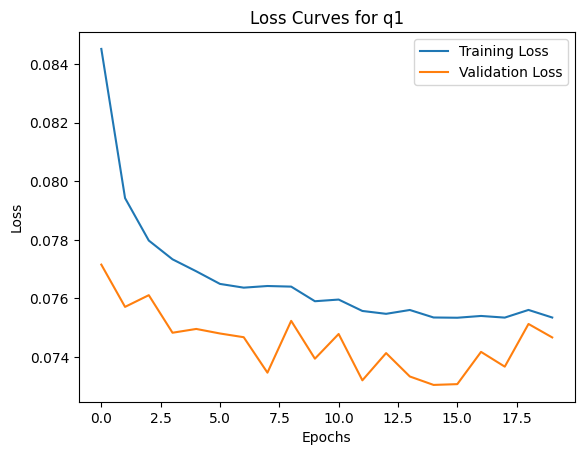

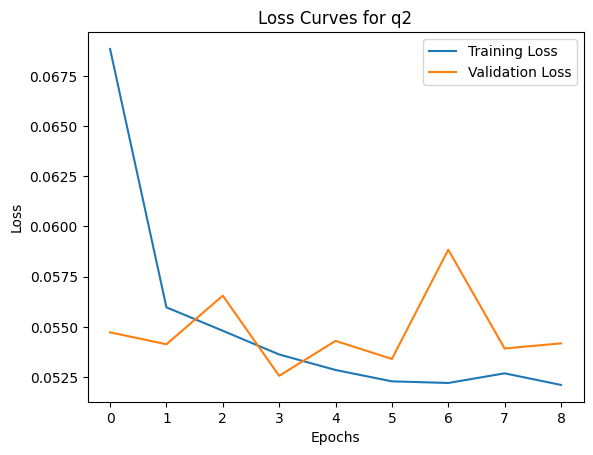

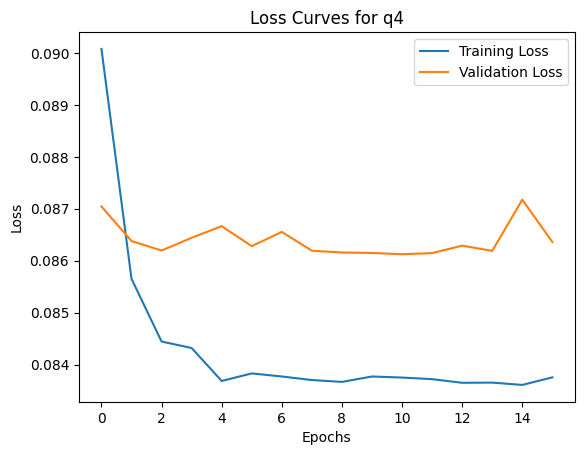

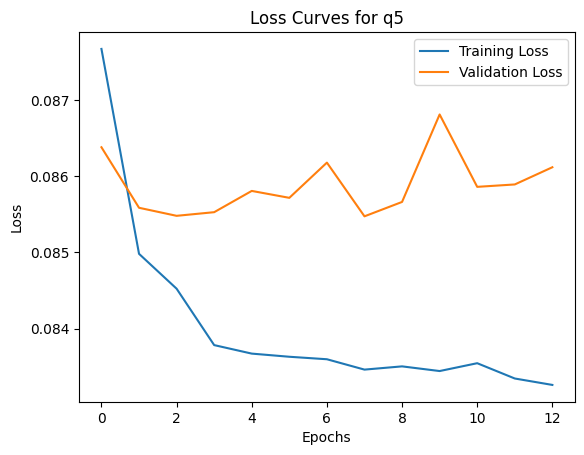

In [38]:
# Plot the loss curves for all models
import matplotlib.pyplot as plt

for i, history in enumerate(histories):
    plt.figure()
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Loss Curves for {y.columns[i]}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

plt.show()